In [20]:
from keras.datasets import boston_housing
from keras import regularizers
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [7]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape, test_data.shape)

(404, 13) (102, 13)


In [8]:
# Нормализация данных
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [28]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                            kernel_regularizer=regularizers.l1(0.01),
                            input_shape=(train_data.shape[1],)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu',
                           kernel_regularizer=regularizers.l1(0.001)))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [29]:
# Перекрёстная проверка по К блокам
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
#all_scores = []
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)

    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)

    model = build_model()
    '''model.fit(partial_train_data, patrail_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)'''
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


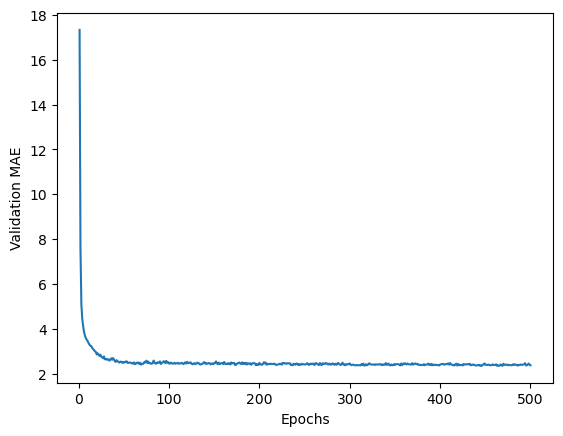

In [30]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show() 

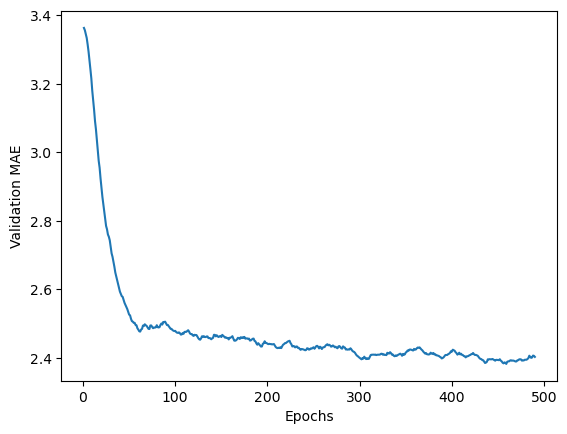

In [31]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [32]:
callbacks = [EarlyStopping(patience=10, monitor='mae', restore_best_weights=True)]

model = build_model()
model.fit(train_data,
          train_targets,
          epochs=200,
          batch_size=16,
          callbacks=callbacks,
          verbose=1)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

Epoch 1/200
26/26 [==============================] - 1s 2ms/step - loss: 567.4789 - mae: 21.9600
Epoch 2/200
26/26 [==============================] - 0s 1ms/step - loss: 535.1071 - mae: 21.2867
Epoch 3/200
26/26 [==============================] - 0s 1ms/step - loss: 492.2419 - mae: 20.3718
Epoch 4/200
26/26 [==============================] - 0s 1ms/step - loss: 441.9252 - mae: 19.1982
Epoch 5/200
26/26 [==============================] - 0s 1ms/step - loss: 386.6817 - mae: 17.8490
Epoch 6/200
26/26 [==============================] - 0s 1ms/step - loss: 328.7577 - mae: 16.2357
Epoch 7/200
26/26 [==============================] - 0s 1ms/step - loss: 271.2657 - mae: 14.4500
Epoch 8/200
26/26 [==============================] - 0s 1ms/step - loss: 221.2912 - mae: 12.7036
Epoch 9/200
26/26 [==============================] - 0s 1ms/step - loss: 172.5773 - mae: 10.7715
Epoch 10/200
26/26 [==============================] - 0s 1ms/step - loss: 139.7506 - mae: 9.4141
Epoch 11/200
26/26 [==========